# Data Pre-Processing
## Import Libraries

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Import Cleaned Dataset

In [3]:
df = pd.read_csv('Data/cleaned.csv')

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,inn00001,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,2,offline,0,0,0,65.00,0,not_canceled
1,inn00002,2,0,2,3,not selected,0,room_type 1,5,2018,11,6,online,0,0,0,106.68,1,not_canceled
2,inn00003,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,28,online,0,0,0,60.00,0,canceled
3,inn00004,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,20,online,0,0,0,100.00,0,canceled
4,inn00005,2,0,1,1,not selected,0,room_type 1,48,2018,4,11,online,0,0,0,94.50,0,canceled


In [34]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

## Columns Preparation

In [4]:
# encode booking_status
df['booking_status'] = df['booking_status'].apply(lambda x: 1 if x=='canceled' else 0)

In [145]:
# create booking_date
temp = df.rename(columns={
    'arrival_year': 'year',
    'arrival_month': 'month',
    'arrival_date': 'day'
})

df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
df['booking_date'] = df['booking_date'] - pd.Series(
    [pd.Timedelta(i, 'd') for i in df.lead_time],
    index=df.index
)

## Train-Test Split

There are two possible methods for train-test split:
1. Randomly split with 80/20 rule
2. Split base on booking date, such that entries in earlier dates will be under training set and those in later dates will be under test set

We will adopt method 2, because in real-life senarios, we are likely to use only historical data to make prediction for future data. At the same time, the size of training and test set will be around 80:20.

In [14]:
# split based on booking_date
train = df[df['booking_date']<'2018-07-01'].reset_index(drop=True)
test = df[df['booking_date']>='2018-07-01'].reset_index(drop=True)

In [16]:
print(f'Size of training set: {len(train)}')
print(f'Size of test set: {len(test)}')

Size of training set: 28062
Size of test set: 8176


## Feature Engineering on Categorical Variables

In [1]:
cat_cols = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'repeated_guest', 'market_segment_type']

There are several ways for encoding categorical varaibles:
1. LabelEncoder: Assigns a unique integer to each category, suitable for ordinal data where the categories have a natural order
2. OrdinalEncoder: Preserves the ordinal relationship between categories, useful when the categorical variables have an inherent order
3. OneHotEncoder: Creates binary columns for each category, indicating the presence or absence of each category, suitable for nominal data with no ordinal relationship
4. TargetEncoder: Replaces categories with the mean of the target variable for each category, useful for high-cardinality categorical variables

For the above variables, they have small cardinalities and are norminal data, so OneHotEncoding is the most suitable method.

In [25]:
# fit on training data
enc = OneHotEncoder(handle_unknown='error')
enc.fit(train[cat_cols])
train[enc.get_feature_names_out()] = enc.transform(train[cat_cols]).toarray()

train.drop(columns=cat_cols, inplace=True)

In [26]:
# transform test data
test[enc.get_feature_names_out()] = enc.transform(test[cat_cols]).toarray()

test.drop(columns=cat_cols, inplace=True)

In [82]:
# store the categorical column names after encoding
encoded_cat_cols = enc.get_feature_names_out()

For now, all categories are kept to ensure interpretability. To avoid multicollinearity issues in linear models, an extra step needs to be done to remove one of the categories.

## Feature Engineering on Numerical Variables

There are 2 possible methods to handle numerical variables:
1. Discretize the variables into a few categories. While this method can improve interpretability and reduce sensitivity to outliers, it may cause information loss
2. Scale the variables to facilitate algorithms that require gradient descent or distance measurement

In the following sections, the 2 methods will be implemented separately, and they will be fed into a logistic regression model to compare the performance.

### Discretization

The following variables have fewer unique values and will be visualized with countplots.

In [28]:
spec_num_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']

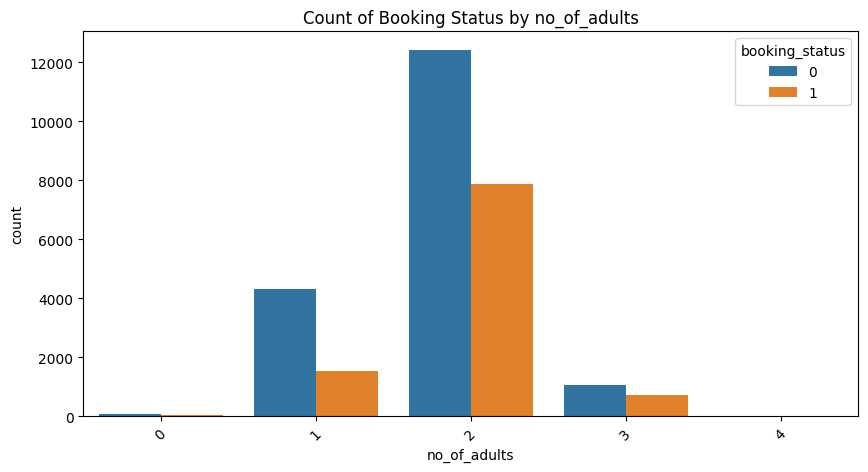

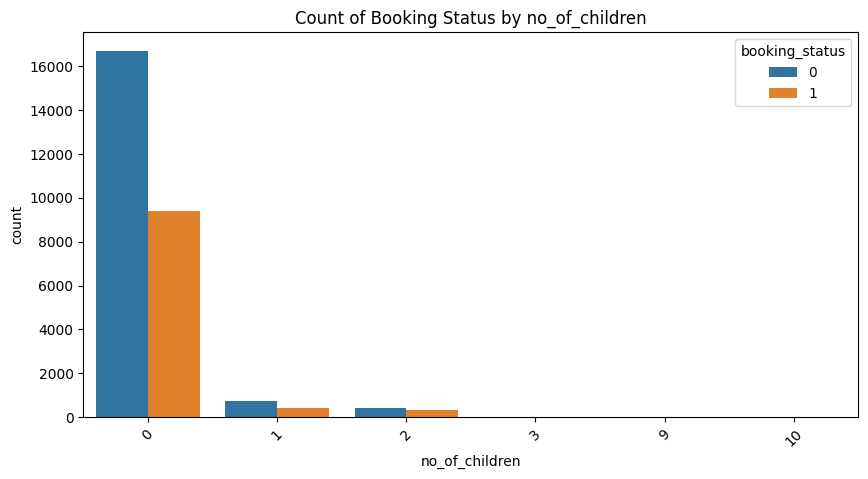

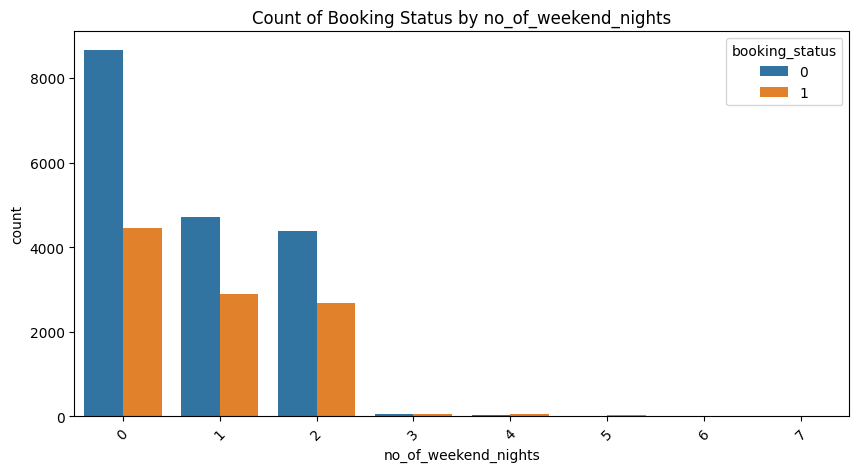

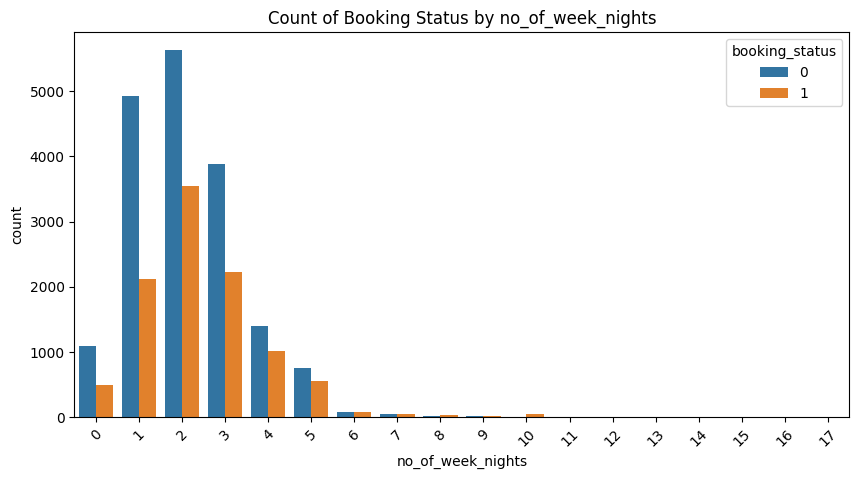

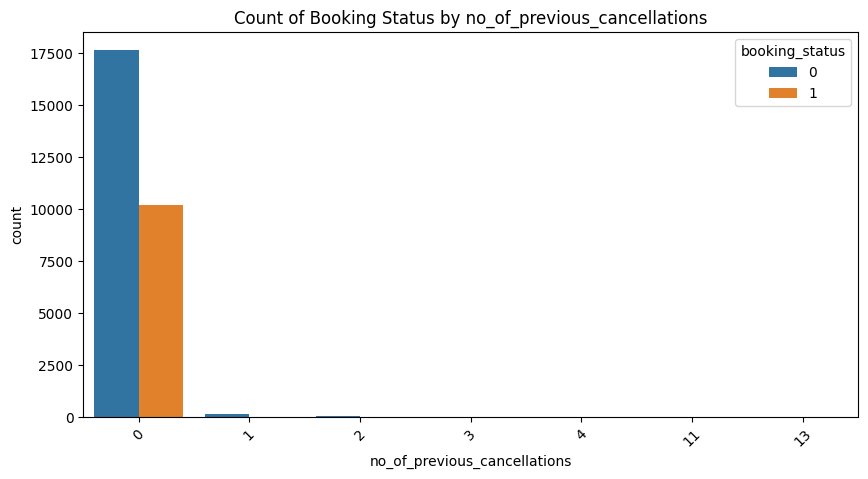

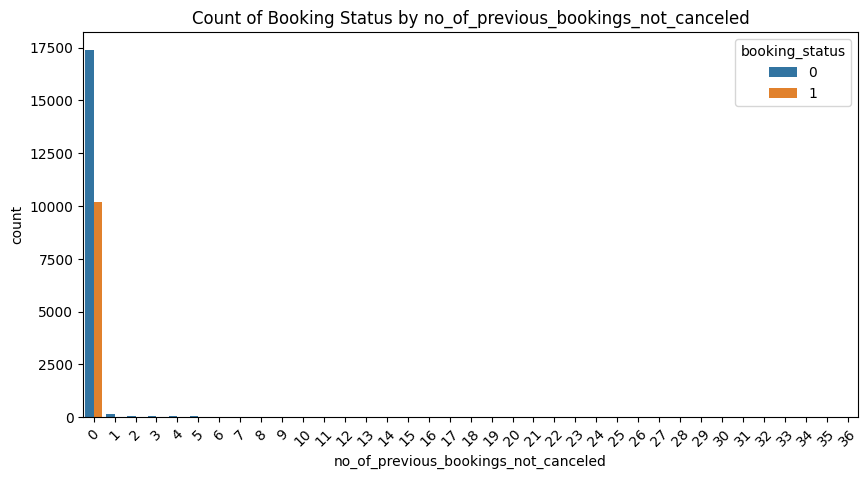

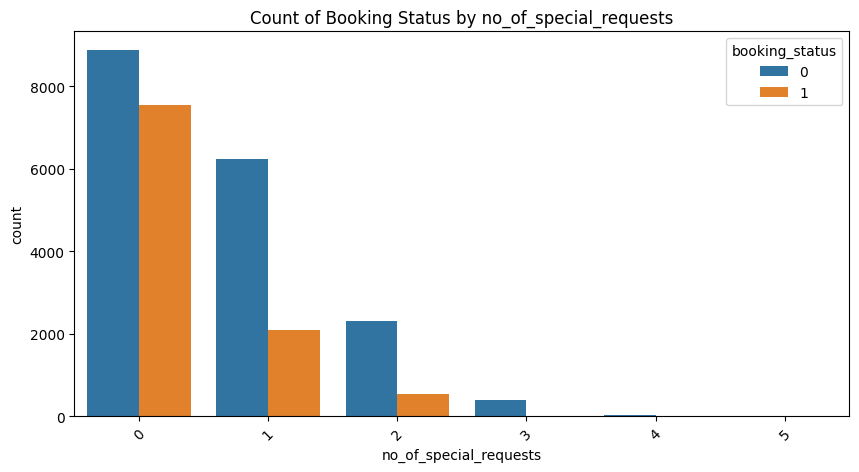

In [30]:
for col in spec_num_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=train)
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

With the above visualizations, the following rules will be implemented to reduce the effect of outliers:
1. no_of_adults: observations with no_of_adults>3 will be group into one category, while 0, 1, 2, 3 will be separate categories
2. no_of_children: observations with no_of_children>2 will be group into one category, while 0, 1, 2 will be separate categories
3. no_of_weekend_nights: observations with no_of_weekend_nights>2 will be group into one category, while 0, 1, 2 will be separate categories
4. no_of_week_nights: observations with no_of_week_nights>7 will be group into one category, while the others will be separate categories
5. no_of_previous_cancellations: this variable will be converted to a boolean variable, i.e. whether or not cancelled before
6. no_of_previous_bookings_not_canceled: this variable will be converted to a boolean variable, i.e. whether or not had uncancelled bookings before
7. no_of_special_requests: observations with no_of_special_requests>2 will be group into one category, while 0, 1, 2 will be separate categories

In [59]:
# no_of_adults: create a >3 category
train['no_of_adults_cat'] = train['no_of_adults'].apply(lambda x: str(x) if x<=3 else 'greater than 3')

# no_of_children: create a >2 category
train['no_of_children_cat'] = train['no_of_children'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_weekend_nights: create a >2 category -> stay for more than one week
train['no_of_weekend_nights_cat'] = train['no_of_weekend_nights'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_week_nights: create a >7 category -> stay for more than one week
train['no_of_week_nights_cat'] = train['no_of_week_nights'].apply(lambda x: str(x) if x<=7 else 'greater than 7')

# no_of_previous_cancellations: convert to binary
train['no_of_previous_cancellations_cat'] = train['no_of_previous_cancellations'].apply(lambda x: x if x==0 else 1)

# no_of_previous_bookings_not_canceled: convert to binary
train['no_of_previous_bookings_not_canceled_cat'] = train['no_of_previous_bookings_not_canceled'].apply(lambda x: x if x==0 else 1)

# no_of_special_requests: create a >2 category
train['no_of_special_requests_cat'] = train['no_of_special_requests'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

The following variables have a substantial number of unique values and will be visualized with histplot.

In [50]:
num_cols = ['lead_time', 'avg_price_per_room']

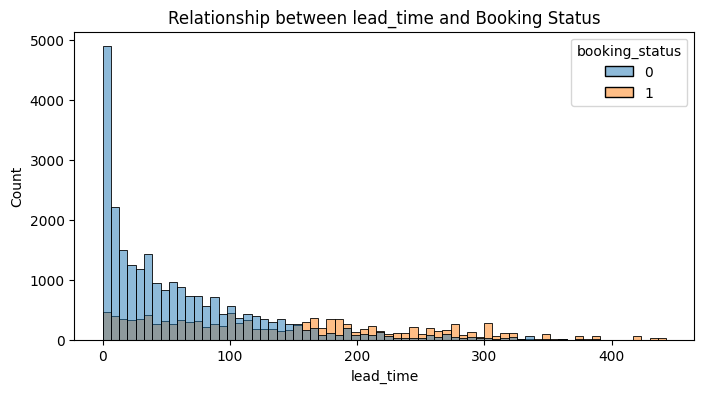

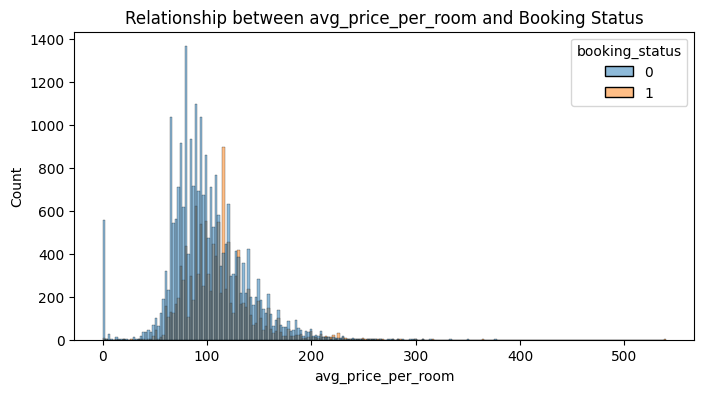

In [51]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(x=col, hue='booking_status', data=df)
    plt.title(f'Relationship between {col} and Booking Status')
    plt.show()

These 2 numerical variables will be binned into: 0 to 50, 50 to 100, 100 to 150, 200 to 300, and greater than 300 categories.

In [61]:
def binning(x):
    if x<=50:
        return 'cat 1: 0 to 50'
    elif x<=100:
        return 'cat 2: 50 to 100'
    elif x<=150:
        return 'cat 3: 100 to 150'
    elif x<=200:
        return 'cat 4: 150 to 200'
    elif x<=300:
        return 'cat 5: 200 to 300'
    else:
        return 'cat 6: greater than 300'

In [62]:
# lead_time
train['lead_time_cat'] = train['lead_time'].apply(binning)

# avg_price_per_room
train['avg_price_per_room_cat'] = train['avg_price_per_room'].apply(binning)

In [57]:
# store the numerical column names after discretization
spec_cat_cols = ['no_of_adults_cat', 'no_of_children_cat', 'no_of_weekend_nights_cat', 'no_of_week_nights_cat', 'no_of_previous_cancellations_cat', 'no_of_previous_bookings_not_canceled_cat', 'no_of_special_requests_cat', 'lead_time_cat', 'avg_price_per_room_cat']

The variables after discretization will be visualized again.

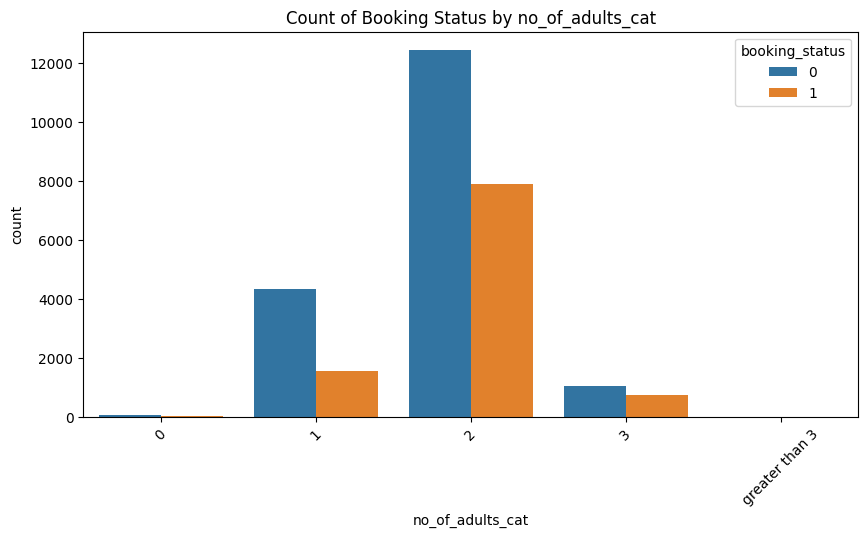

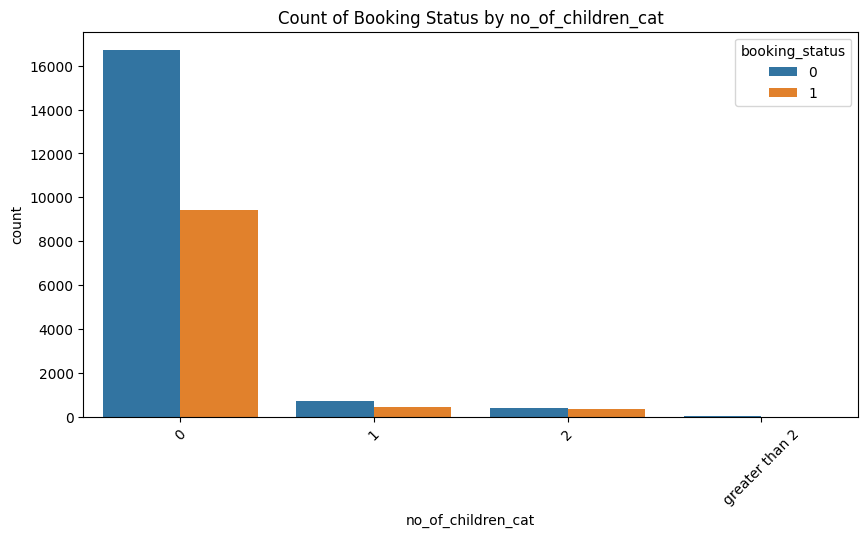

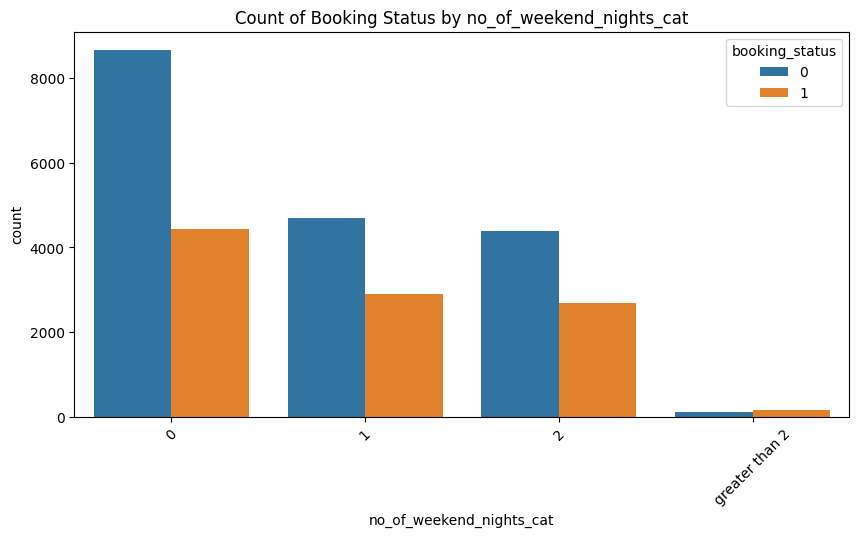

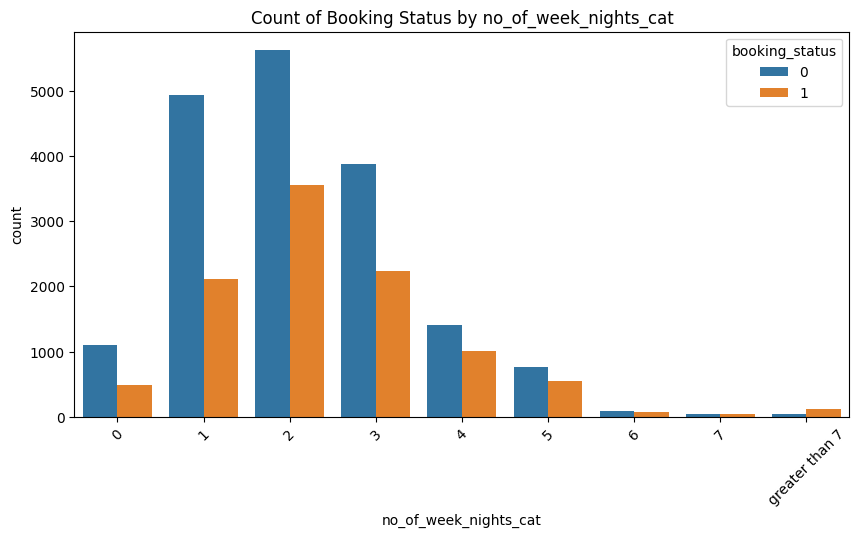

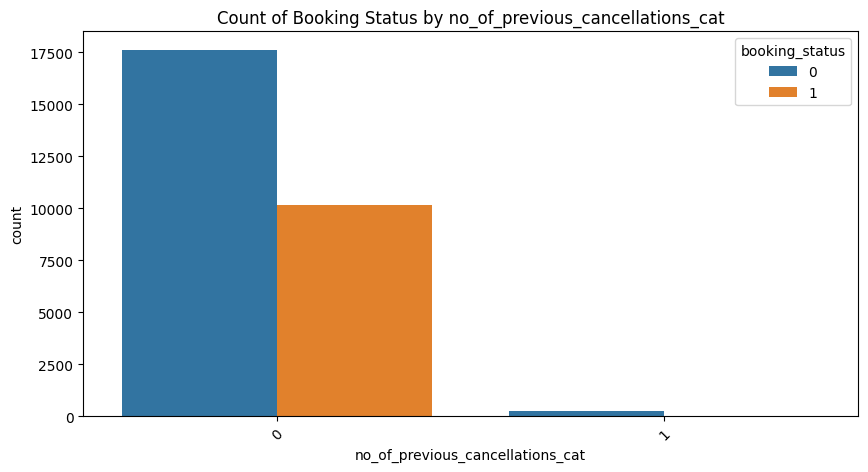

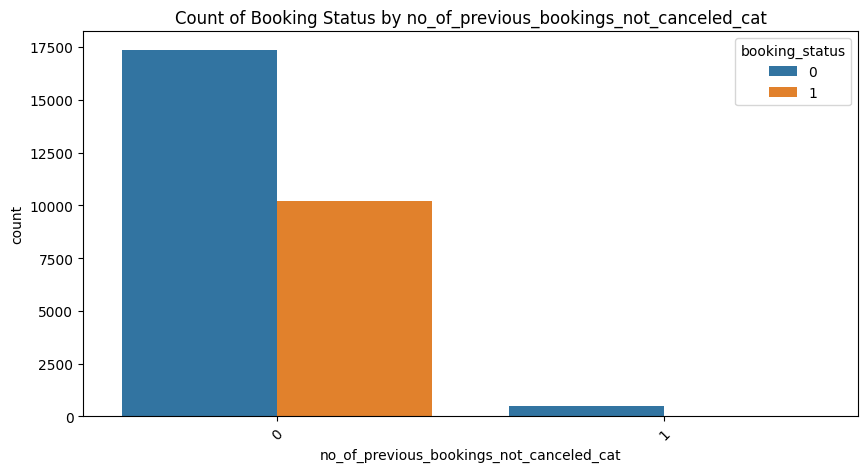

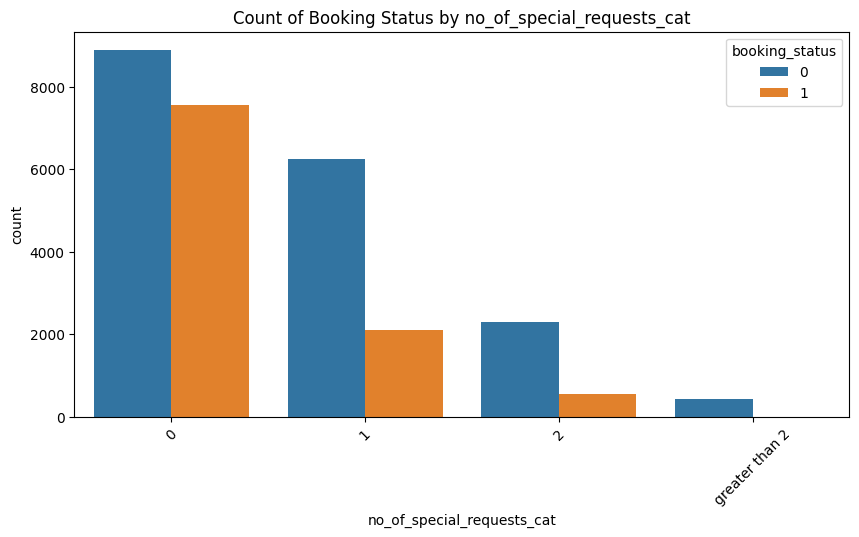

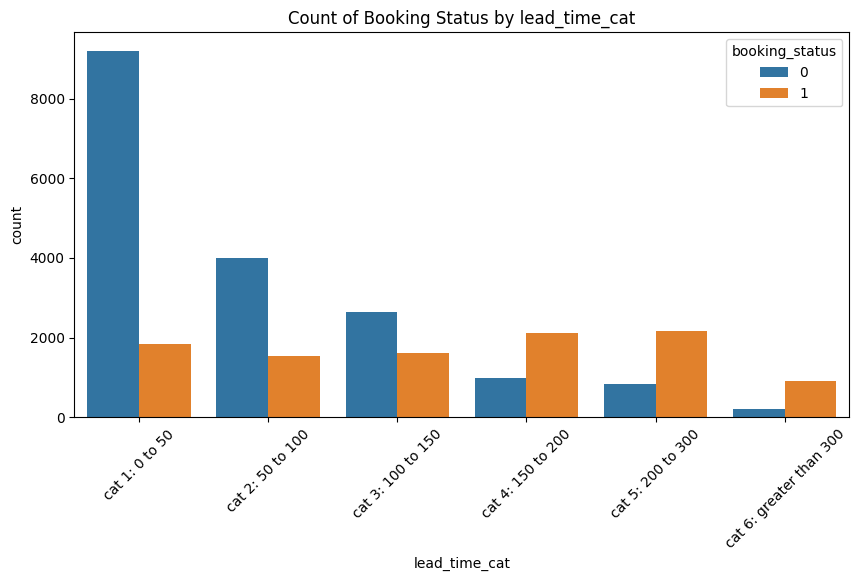

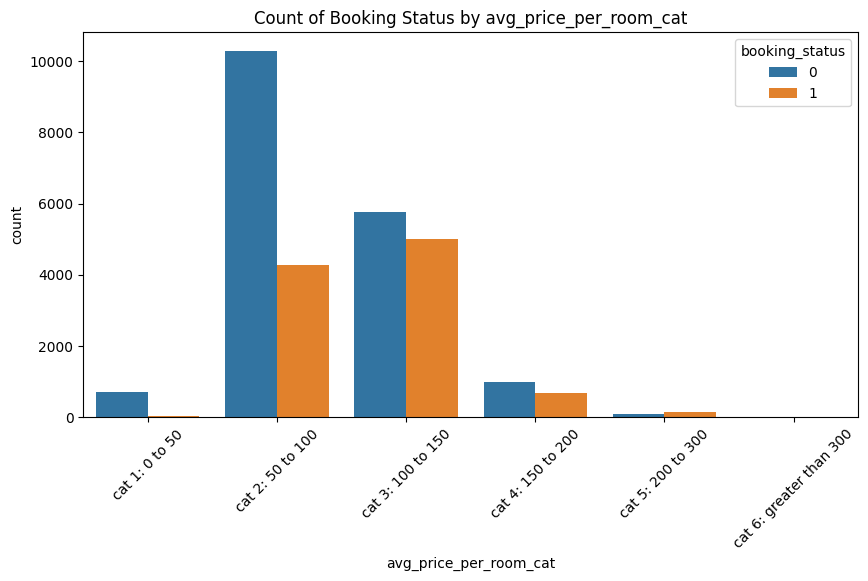

In [63]:
for col in spec_cat_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=train, order=sorted(train[col].unique()))
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

Test data will be discretized in the same way.

In [64]:
# no_of_adults: create a >3 category
test['no_of_adults_cat'] = test['no_of_adults'].apply(lambda x: str(x) if x<=3 else 'greater than 3')

# no_of_children: create a >2 category
test['no_of_children_cat'] = test['no_of_children'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_weekend_nights: create a >2 category -> stay for more than one week
test['no_of_weekend_nights_cat'] = test['no_of_weekend_nights'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_week_nights: create a >7 category -> stay for more than one week
test['no_of_week_nights_cat'] = test['no_of_week_nights'].apply(lambda x: str(x) if x<=7 else 'greater than 7')

# no_of_previous_cancellations: convert to binary
test['no_of_previous_cancellations_cat'] = test['no_of_previous_cancellations'].apply(lambda x: x if x==0 else 1)

# no_of_previous_bookings_not_canceled: convert to binary
test['no_of_previous_bookings_not_canceled_cat'] = test['no_of_previous_bookings_not_canceled'].apply(lambda x: x if x==0 else 1)

# no_of_special_requests: create a >2 category
test['no_of_special_requests_cat'] = test['no_of_special_requests'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

In [65]:
# lead_time
test['lead_time_cat'] = test['lead_time'].apply(binning)

# avg_price_per_room
test['avg_price_per_room_cat'] = test['avg_price_per_room'].apply(binning)

Again, these categorical variables need to be encoded, and OneHotEncoding will be adopted.

In [66]:
# fit on training data
enc_spec = OneHotEncoder(handle_unknown='error')
enc_spec.fit(train[spec_cat_cols])
train[enc_spec.get_feature_names_out()] = enc_spec.transform(train[spec_cat_cols]).toarray()

train.drop(columns=spec_cat_cols, inplace=True)

In [67]:
# transform test data
test[enc_spec.get_feature_names_out()] = enc_spec.transform(test[spec_cat_cols]).toarray()

test.drop(columns=spec_cat_cols, inplace=True)

In [77]:
# store the numerical column names after encoding
encoded_num_cols = enc_spec.get_feature_names_out()

### Scaling

For machine learning algorithm that requires gradient descent or distance measurement, feature scaling is necessary. There are several ways of scaling:
1. Min-Max Scaling: Scales the data to a fixed range, usually between 0 and 1, useful when the distribution of data is uniform or when the algorithm requires input features to be on a similar scale
2. Standardization: Scales the data to have a mean of 0 and a standard deviation of 1, preserves the shape of the original distribution and is less affected by outliers
3. Robust Scaling: Scales the data based on the interquartile range (IQR) to mitigate the effect of outliers

As observations with extreme values exist in our data and the distribution of data is not of a specific distribution, we will adopt Standardization.

In [75]:
# fit on training data
scaler = StandardScaler()
scaler.fit(train[spec_num_cols+num_cols])
train[[x+'_scaled' for x in spec_num_cols+num_cols]] = scaler.transform(train[spec_num_cols+num_cols])

In [76]:
# transform test data
test[[x+'_scaled' for x in spec_num_cols+num_cols]] = scaler.transform(test[spec_num_cols+num_cols])

In [92]:
# store the numerical column names after scaling
scaled_num_cols = [x+'_scaled' for x in spec_num_cols+num_cols]

## Examination with Logistic Regression

Train and test set will first be prepared for model building. Then a logistic regression will be fitted to the 2 sets of processed data and compared the performance:
1. encoded categorical variables + discretized and encoded numerical variables
2. encoded categorical variables + scaled numerical variables

In [153]:
X_train = train.drop(['booking_status', 'Booking_ID'], axis = 1)
Y_train = train['booking_status']
X_test = test.drop(['booking_status', 'Booking_ID'], axis = 1)
Y_test = test['booking_status']

### encoded categorical variables + discretized and encoded numerical variables

In [159]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train[list(encoded_cat_cols)+list(encoded_num_cols)], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[list(encoded_cat_cols)+list(encoded_num_cols)])
Y_test_pred = logRegModel.predict(X_test[list(encoded_cat_cols)+list(encoded_num_cols)])

In [160]:

# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.8061079039270187
Precision 	: 0.7503949447077409
Recall 		: 0.6988034523342487
F1 Score 	: 0.7236808694327358

**Test Set Metrics**
Accuracy 	: 0.8090753424657534
Precision 	: 0.5555555555555556
Recall 		: 0.35969084423305586
F1 Score 	: 0.4366654637315049


### encoded categorical variables + scaled numerical variables

In [ ]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train[list(encoded_cat_cols)+list(scaled_num_cols)], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[list(encoded_cat_cols)+list(scaled_num_cols)])
Y_test_pred = logRegModel.predict(X_test[list(encoded_cat_cols)+list(scaled_num_cols)])

In [162]:
# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.8018672938493336
Precision 	: 0.7556241729157477
Recall 		: 0.6720282463711259
F1 Score 	: 0.7113787375415282

**Test Set Metrics**
Accuracy 	: 0.8175146771037182
Precision 	: 0.5899621212121212
Recall 		: 0.3703923900118906
F1 Score 	: 0.4550766983199416


From the results, it can be seen that scaling the numerical variables provides us better results. While discretizing all numerical variables do not help improve the performance, individual numerical feature may still be discretized, which will be experimented more under Feature Engineering.